In [1]:
from astroquery.skyview import SkyView
from astroquery.mast import Observations
from astroquery.vizier import Vizier
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import cv2
import numpy as np
from astropy.io import fits
import os
import pandas as pd
import requests
import json

In [2]:
# List available surveys
surveys = SkyView.list_surveys()
print(surveys)

{'Allbands:GOODS/HDF/CDF': ['GOODS: Chandra ACIS HB',
                            'GOODS: Chandra ACIS FB',
                            'GOODS: Chandra ACIS SB',
                            'GOODS: VLT VIMOS U',
                            'GOODS: VLT VIMOS R',
                            'GOODS: HST ACS B',
                            'GOODS: HST ACS V',
                            'GOODS: HST ACS I',
                            'GOODS: HST ACS Z',
                            'Hawaii HDF U',
                            'Hawaii HDF B',
                            'Hawaii HDF V0201',
                            'Hawaii HDF V0401',
                            'Hawaii HDF R',
                            'Hawaii HDF I',
                            'Hawaii HDF z',
                            'Hawaii HDF HK',
                            'GOODS: HST NICMOS',
                            'GOODS: VLT ISAAC J',
                            'GOODS: VLT ISAAC H',
                            'GOODS: 

In [3]:
# Define the coordinates for the Eagle Nebula Pillars of Creation
coords = SkyCoord('18h18m48s -13d49m00s', frame='icrs')
# Track the name of the object
object_name = 'Eagle Nebula Pillars of Creation'

In [4]:
# Fetch an image from SkyView
# image_list = SkyView.get_images(position=coords, survey=['DSS'], radius=0.1 * u.deg)
# image_list = SkyView.get_images(position=coords, survey=['DSS'], radius=0.25 * u.deg)
# image_list = SkyView.get_images(position=coords, survey=['DSS'], radius=0.5 * u.deg)
# image_list = SkyView.get_images(position=coords, survey=['DSS'], radius=1 * u.deg)

image_list = SkyView.get_images(position=coords, survey=['DSS1 Blue'], radius=0.25 * u.deg)
# image_list = SkyView.get_images(position=coords, survey=['DSS1 Red'], radius=0.25 * u.deg)
# image_list = SkyView.get_images(position=coords, survey=['DSS2 Red'], radius=0.25 * u.deg)

image_hdu = image_list[0][0]
image = image_list[0][0].data

In [5]:
# Create a folder for the object with the name of the object with underscores instead of spaces
object_name = object_name.replace(' ', '_')
os.makedirs(f'images/{object_name}', exist_ok=True)

In [6]:
image_hdu.header

SIMPLE  =                    T / Written by SkyView Mon Oct 07 03:13:34 EDT 2024
BITPIX  =                  -32 / 4 byte floating point                          
NAXIS   =                    2 / Two dimensional image                          
NAXIS1  =                  300 / Width of image                                 
NAXIS2  =                  300 / Height of image                                
CRVAL1  =                274.7 / Reference longitude                            
CRVAL2  =             -13.8167 / Reference latitude                             
RADESYS = 'FK5     '           / Coordinate system                              
EQUINOX =               2000.0 / Epoch of the equinox                           
CTYPE1  = 'RA---TAN'           / Coordinates -- projection                      
CTYPE2  = 'DEC--TAN'           / Coordinates -- projection                      
CRPIX1  =                150.5 / X reference pixel                              
CRPIX2  =                150

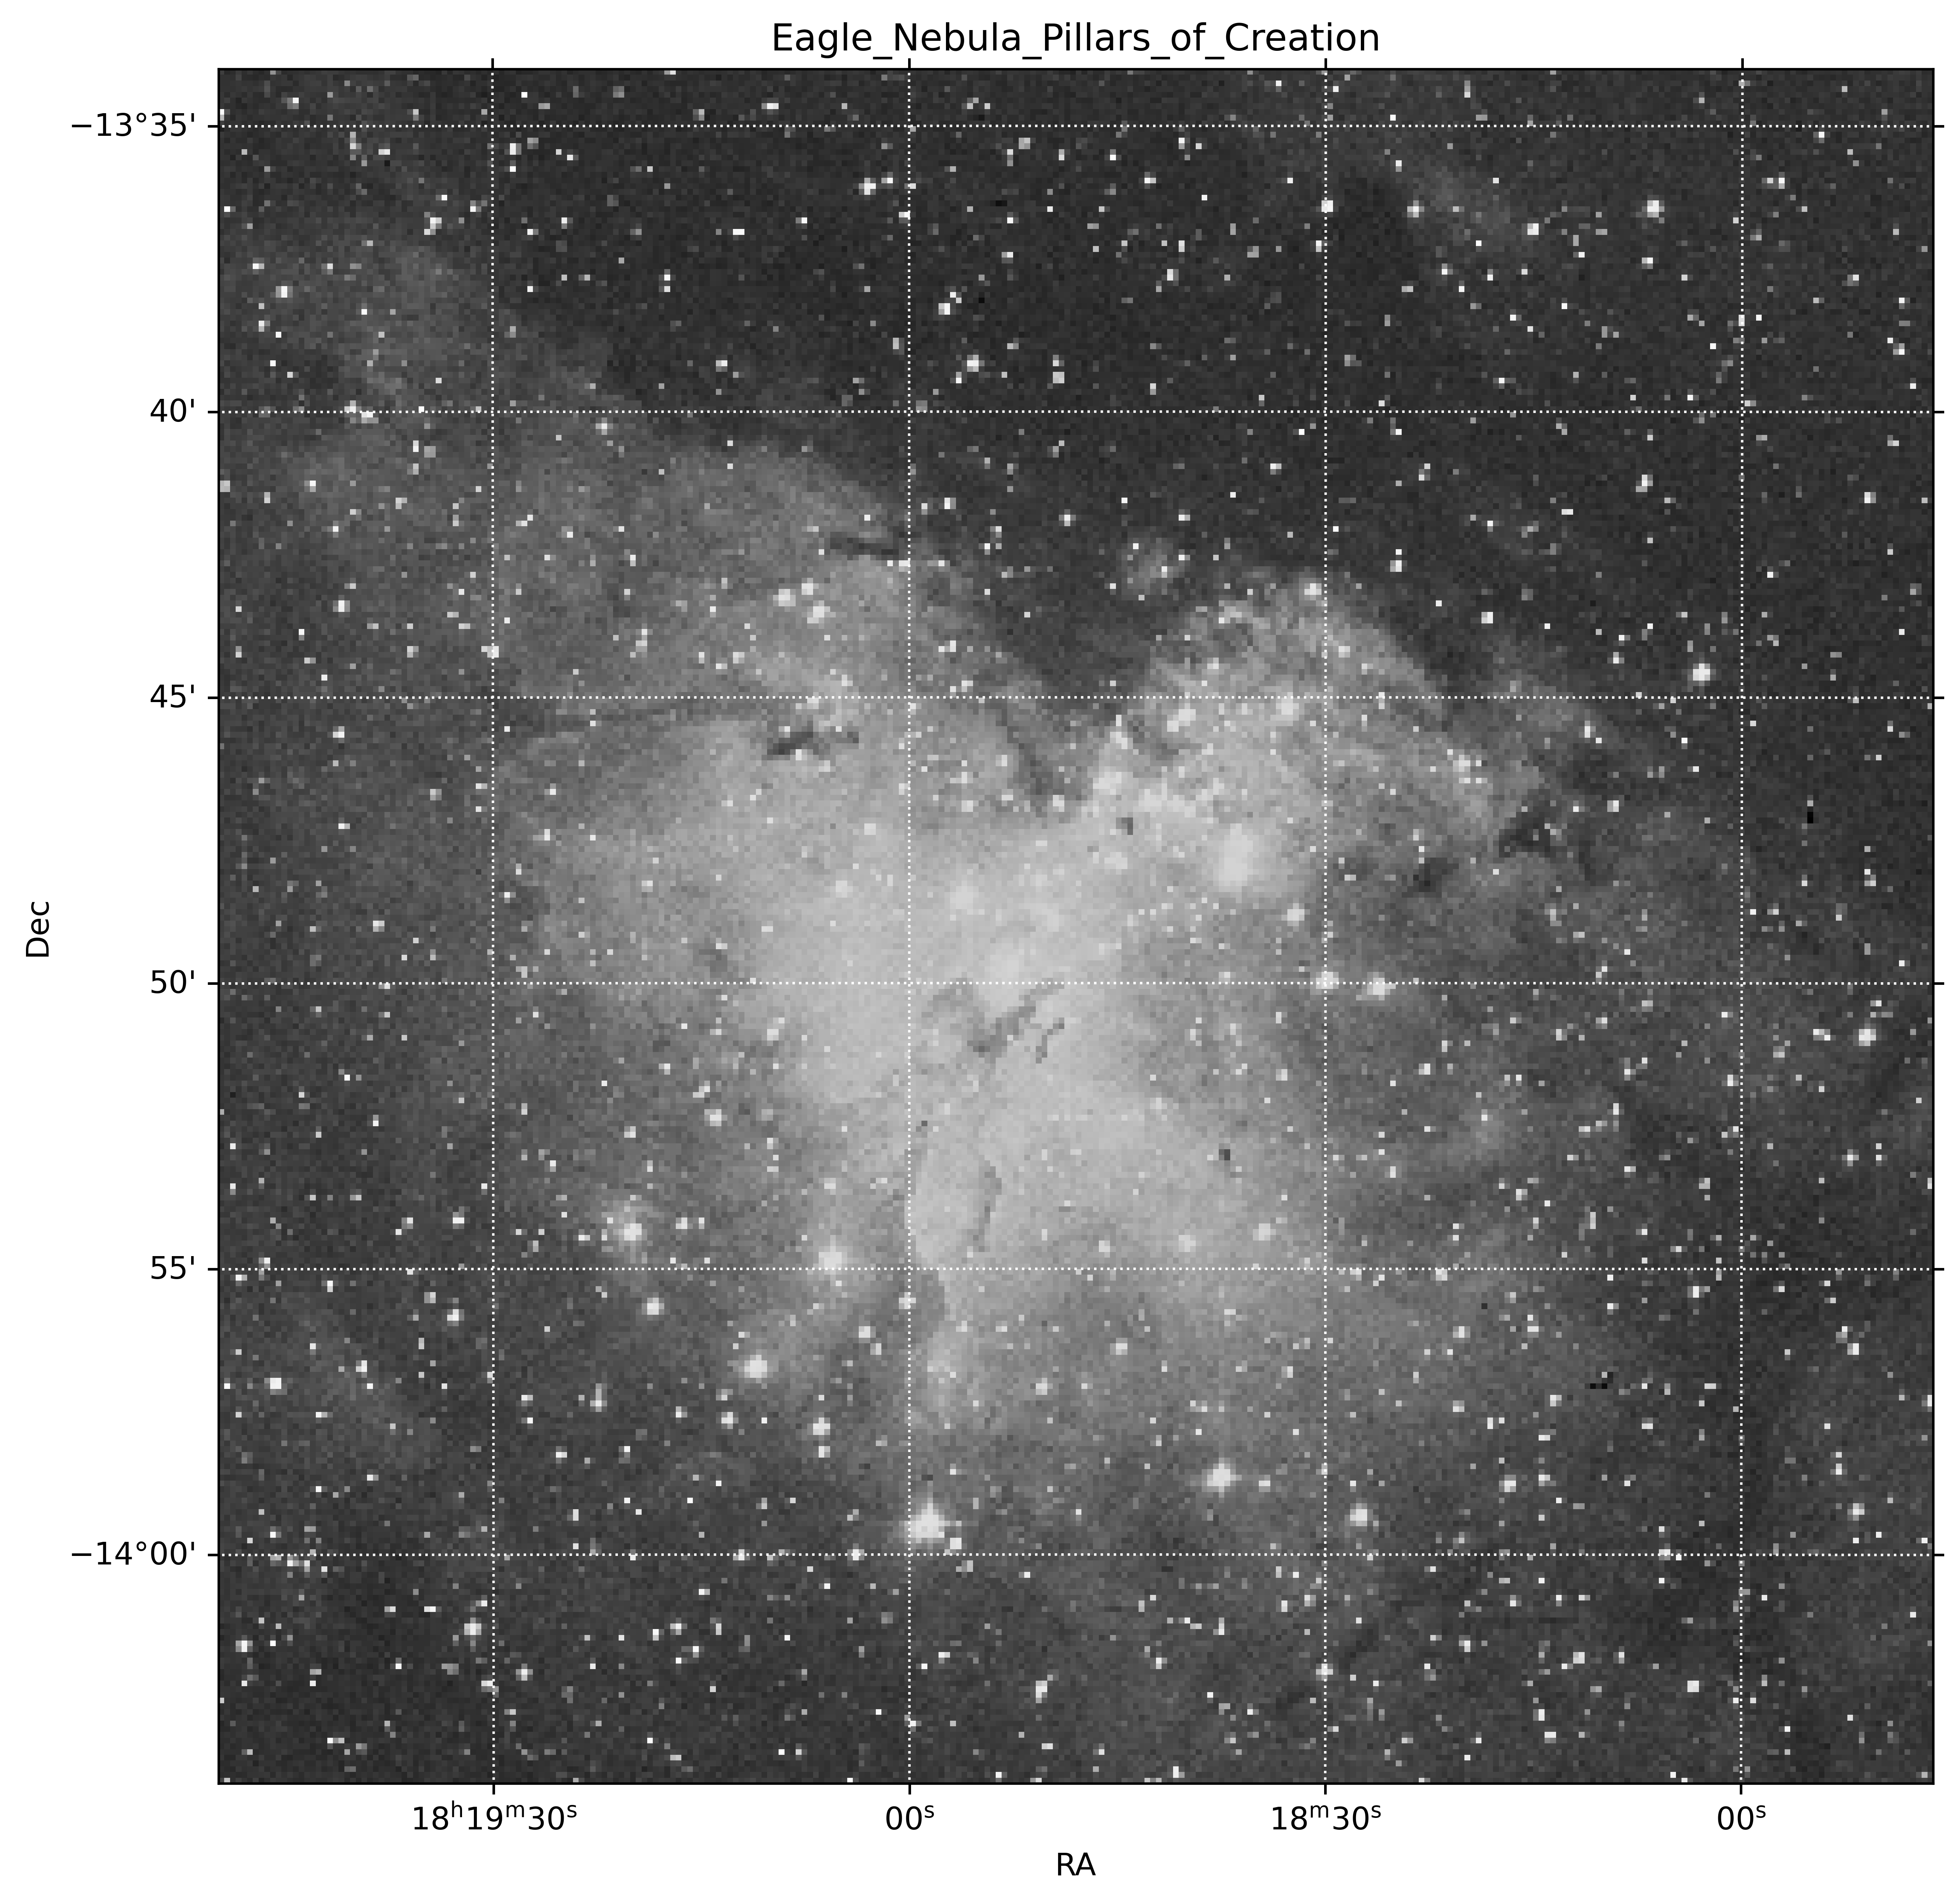

In [7]:
# Extract WCS information
wcs = WCS(image_hdu.header)

# Display the image with WCS projection and grid
fig = plt.figure(figsize=(10, 10), dpi=600)
ax = fig.add_subplot(111, projection=wcs)
ax.imshow(image_hdu.data, cmap='gray', origin='lower')
ax.set_title(f'{object_name}')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.grid(color='white', ls='dotted')

In [8]:
# Fetch star data from Vizier using the 2MASS catalog
v = Vizier(columns=['*'])
catalog_list = v.query_region(coords, radius=0.4 * u.deg, catalog='II/246')
catalog = catalog_list[0]

# Convert the table to a pandas DataFrame for easier manipulation
catalog = catalog.to_pandas()
print(catalog)

       RAJ2000    DEJ2000            _2MASS       Jmag  e_Jmag    Hmag  \
0   274.591182 -14.197840  18182188-1411522  14.590000   0.070  13.087   
1   274.590466 -14.192979  18182171-1411347  16.683001     NaN  14.343   
2   274.597878 -14.198063  18182349-1411530  15.290000   0.069  14.290   
3   274.594712 -14.196480  18182273-1411473  14.004000   0.033  13.144   
4   274.597156 -14.199730  18182331-1411590  13.644000   0.056  12.099   
5   274.596356 -14.198669  18182312-1411552  15.266000   0.106  14.273   
6   274.592847 -14.193782  18182228-1411376  15.020000   0.067  13.295   
7   274.593500 -14.195029  18182244-1411421  15.729000     NaN  14.372   
8   274.593262 -14.199013  18182238-1411564  15.326000   0.057  13.617   
9   274.591735 -14.196143  18182201-1411461  15.455000   0.086  14.373   
10  274.597256 -14.201527  18182334-1412054  14.576000   0.047  12.924   
11  274.592545 -14.202754  18182221-1412099  16.246000   0.128  14.114   
12  274.607786 -14.205789  18182586-14

In [9]:
# Fetch star data from Vizier using the Hipparcos catalog
v = Vizier(columns=['*'])
catalog_list = v.query_region(coords, radius=2 * u.deg, catalog='I/239/hip_main')
catalog = catalog_list[0]

# Convert the table to a pandas DataFrame for easier manipulation
catalog = catalog.to_pandas()
print(catalog)

      HIP        RAhms        DEdms   Vmag      RAICRS     DEICRS        Plx  \
0   89194  18 12 09.00  -14 00 28.4   9.36  273.037504 -14.007884   2.750000   
1   89263  18 12 56.15  -15 11 32.5   8.18  273.233946 -15.192370   3.370000   
2   89292  18 13 14.17  -14 26 07.1   8.54  273.309027 -14.435309   2.850000   
3   89422  18 14 57.76  -15 23 05.1   7.09  273.740646 -15.384736   7.860000   
4   89436  18 15 11.90  -12 30 04.1   8.61  273.799591 -12.501129  -0.140000   
5   89441  18 15 13.26  -12 32 12.3   8.22  273.805261 -12.536744  -1.690000   
6   89508  18 15 54.86  -13 34 27.7   8.22  273.978586 -13.574355   1.550000   
7   89518  18 16 02.14  -14 55 27.0   7.82  274.008919 -14.924175   4.550000   
8   89519  18 16 02.29  -14 18 21.2   9.22  274.009552 -14.305892   4.930000   
9   89626  18 17 26.01  -14 50 56.4   7.98  274.358384 -14.848987   6.250000   
10  89634  18 17 31.12  -14 27 08.9   8.91  274.379677 -14.452475   6.000000   
11  89641  18 17 37.71  -15 25 50.6   6.

In [10]:
# # Example preprocessing steps
# # Normalize the image
# normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))

In [11]:
# # Extract star positions and magnitudes
# star_positions = np.array([stars['RAJ2000'], stars['DEJ2000']]).T
# star_magnitudes = stars['Vmag']

In [12]:
# # Save preprocessed data for further analysis
# np.save('preprocessed_image.npy', normalized_image)
# star_data = pd.DataFrame({'RA': stars['RAJ2000'], 'Dec': stars['DEJ2000'], 'Magnitude': stars['Vmag']})
# star_data.to_csv('preprocessed_star_data.csv', index=False)

In [13]:
# # Save the image using OpenCV
# cv2.imwrite('sky_image.png', image)